In [1]:
import branches
import metrics
import plotting
import preprocess
import segmentation
import thresholding
import file
import basicrna
import search
import trees
import assignment
import transcriptomics
import boundaries
import colors

import cProfile

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import skimage.morphology as morphology
from skimage.measure import label

from collections import Counter
from tqdm import tqdm

In [2]:
parent_directory = os.path.split(file.current_directory)[0]
datapath = parent_directory + "\\training\\0520\\"
datapath_two = parent_directory + "\\training\\0605\\"
plotpath = parent_directory + "\\plots\\"
plotting.set_dir(plotpath)

In [3]:
# RNA = pd.read_csv(datapath + "barcodes.csv")
RNA = pd.read_csv(datapath + "barcodes_p5_cellCenterDistance.csv")
RNA_two = pd.read_csv(datapath_two + "barcodes.csv")

In [4]:
def save(img,name,dir):
    # saveim = Image.fromarray(img)
    # saveim.save(dir+name)
    np.save(dir+name+".npy",img)

### Create process and body image, generate qtree:

In [5]:

processImageFile = datapath + "processImage.npy"
somaImageFile = datapath + "somaImage.npy"

try:
    processImage = np.load(processImageFile)
    somaImage = np.load(somaImageFile)
    thresholdedProcessImage = np.load(datapath + "thresholdedProcessImage.npy")
    brokenProcessImage = np.load(datapath + "brokenProcessImage.npy")
    cleanedProcessImage = np.load(datapath + "cleanedProcessImage.npy")
    thresholdedSomaImage = np.load(datapath + "thresholdedSomaImage.npy")

    newThreshold = False

except OSError:
    imname = 'preprocessed_Probabilities.png'

    datafile = datapath + imname
    segProbIm = cv2.imread(datafile)

    print("thresholding image")
    thresholdedProcessImage, thresholdedSomaImage = thresholding.threshold_img(segProbIm)
    print("breaking down image")
    brokenProcessImage, togetherskel = segmentation.break_down(thresholdedProcessImage)

    cleanedProcessImage = morphology.remove_small_objects(brokenProcessImage>0,min_size=10,connectivity=1)
    cleanedSomaImage = morphology.remove_small_objects(thresholdedSomaImage>0,min_size=25,connectivity=1)

    processImage = label(cleanedProcessImage,connectivity=1)
    somaImage = label(cleanedSomaImage,connectivity=2)

    save(thresholdedProcessImage, "thresholdedProcessImage", datapath)
    save(brokenProcessImage, "brokenProcessImage", datapath)
    save(cleanedProcessImage, "cleanedProcessImage", datapath)
    save(thresholdedSomaImage, "thresholdedSomaImage", datapath)
    save(processImage, "processImage", datapath)
    save(somaImage, "somaImage", datapath)

    newThreshold = True


In [6]:
## load assignments
try:
    assignments = np.load(datapath+"assignments.npy")
    process_labels = np.load(datapath+"processLabels.npy")
    cell_image = np.load(datapath+"cellImage.npy")
    new_rna = pd.read_csv(datapath+"algRNA.csv")

    # reassign if threshold has just been run
    if newThreshold:
        raise OSError()

except OSError:
    assignments, process_labels, cell_image, new_rna = assignment.start_to_end(processImage, somaImage, RNA)
    cellImage = np.array(cell_image,dtype=np.int)
    permuted_cell_image = plotting.permute_image(cellImage)
    np.save(datapath+"assignments.npy", assignments)
    np.save(datapath+"processLabels.npy", process_labels)
    np.save(datapath+"cellImage.npy", cellImage)
    new_rna.to_csv(datapath+"algRNA.csv")

ab_a, ab_b, a_to_b, b_to_a = metrics.align_rna(RNA, new_rna)
alg_master_accuracy = metrics.accuracy_set(ab_a, ab_b)

humanBodyImage, humanProcessImage, processNames = boundaries.getBoundaries(datapath)

preprocessed = np.array(cv2.imread(datapath+"Preprocessed.png"))
preprocessed = np.dstack((preprocessed[:, :, 2], preprocessed[:, :, :2]))
preprocessed[:, :, 1] //= 2
ilastik = np.array(cv2.imread(datapath+"preprocessed_Probabilities.png"))
ilastik[:, :, 0] //= 2

In [7]:
import importlib
importlib.reload(plt)
importlib.reload(plotting)
plotting.set_dir(plotpath)

In [8]:
# image_rect = [0.0, 0.0, somaImage.shape[0], somaImage.shape[1]]
# mini_rna = RNA.sample(100000)
# qtree, rna_list = trees.convert_to_qtree(RNA, image_rect, 10)
# mini_qtree, mini_rna_list = trees.convert_to_qtree(mini_rna, image_rect, 10)

## Plot Images

In [9]:
bbox = [[700, 700, 500, 500], [2600, 2700, 600, 600]]
# plotting.embedimg(preprocessed, bbox, dir=plotpath, name="preprocessed_embed")
two_map = {0 : '#EDF3FA',
        1 : '#2F5061',
        2 : '#F28066',
        3 : '#5EA2C4',
        4 : '#FFAA96',
        }

two_map = {0 : '#F5FAFF',
        1 : '#2F5061',
        2 : '#F28066',
        3 : '#2790C4',
        4 : '#FF7859',
        }

diverge = {0 : '#EDF3FA',
        1 : '#698EBF',
        2 : '#5CBF84',
        3 : '#E0EB9D',
        4 : '#FFAA96',
        }

two_blue = {0 : '#F5FAFF',
        2 : '#2F5061',
        1 : '#2790C4',
        }

two_orange = {0 : '#F5FAFF',
        1 : '#FFBAAB',
        2 : '#E35434',
        }

two_map_mapped = colors.seqfromdict(two_map)
diverge_mapped = colors.seqfromdict(diverge)

## Preprocessing Figure

In [17]:
### barcode distributions
labeled_rna = RNA[RNA['cell_index'] > 0]
labeled_rna = labeled_rna[labeled_rna['barcode_id'] > 400]
labeled_rna['dendritic'] = labeled_rna['process_index'] > 0
dendrite_rate = labeled_rna.groupby('barcode_id', as_index=False)['dendritic'].mean()
dendrite_rate['is_somatic'] = dendrite_rate['dendritic'] > 0.1

# validate barcodes
validate_rna = RNA_two[RNA_two['cell_index'] > 0]
validate_rna = validate_rna[validate_rna['barcode_id'] > 400]
validate_rna['dendritic'] = validate_rna['process_index'] > 0
dendrite_validate = validate_rna.groupby('barcode_id', as_index=False)['dendritic'].mean()

left, right = dendrite_validate.align(dendrite_rate)
left['is_somatic'] = right['is_somatic']


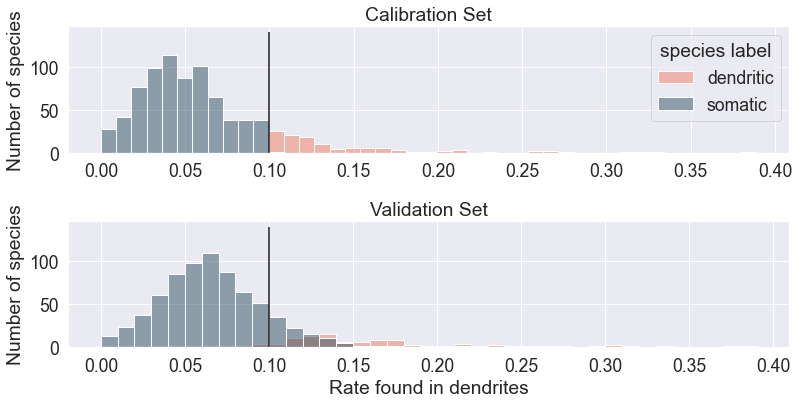

In [24]:
import matplotlib as mpl
mpl.rc('figure',facecolor=[0,0,0,0])
mpl.rc('savefig',dpi=400)

sns.set(font_scale=1.6)
linecolor = 'k'
cmap = [two_map[1], two_map[2]]
shortdim = (11.5, 6)


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=shortdim)

ax = axes[0]
sns.histplot(data=dendrite_rate, ax=ax, x='dendritic', hue='is_somatic', palette=cmap)
ax.set_title("Calibration Set")
ax.set_xlabel(None)
ax.set_ylabel("Number of species")
ax.legend(title='species label', labels=['dendritic', 'somatic'])
ax.vlines([0.1], ymin=0,ymax=140,colors=[linecolor])
# plt.savefig(fname=plotpath+'dendritic_rates.png',bbox_inches='tight')

ax = axes[1]
sns.histplot(data=left, ax=ax, x='dendritic', hue='is_somatic', palette=cmap,legend=False)
ax.set_title('Validation Set')
ax.set_xlabel("Rate found in dendrites")
ax.set_ylabel("Number of species")
# plt.legend(title='species label', labels=['dendritic', 'somatic'])
ax.vlines([0.1], ymin=0,ymax=140,colors=[linecolor])
plt.tight_layout()
plt.savefig(fname=plotpath+'validationdendritc.png',bbox_inches='tight')
plt.show()

In [19]:
def get_quantiles(arr):
    sorted = np.argsort(arr)
    found = np.array([np.argwhere(sorted == i)[0][0] for i in range(len(arr))])
    quantile = found/len(arr)
    return quantile

left['quantile'] = get_quantiles(np.array(left['dendritic']))
right['quantile'] = get_quantiles(np.array(right['dendritic']))

realdiffs = left['quantile'] - right['quantile']

n = len(left)
permutation_one = np.random.choice(range(n), n, replace=False)/n
permutation_two = np.random.choice(range(n), n, replace=False)/n

simdiffs = permutation_one - permutation_two

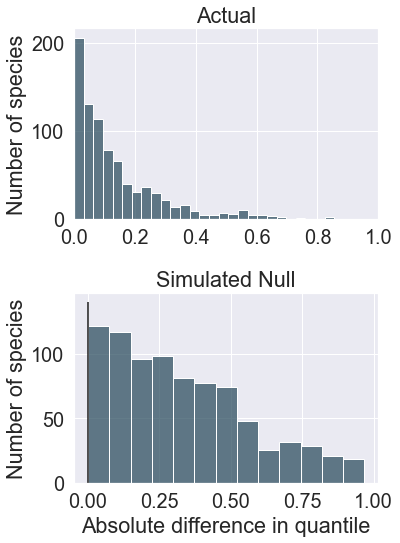

In [25]:

sns.set(font_scale=1.8)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (6,8))

ax = axes[0]
sns.histplot(np.abs(realdiffs), ax=ax, color=cmap[0])
ax.vlines([0], ymin=0,ymax=140,colors=[linecolor])
ax.set_title("Actual")
ax.set_xlim(0,1)
ax.set_xlabel(None)
ax.set_ylabel("Number of species")
# plt.savefig(fname=plotpath+'quantilediff.png',bbox_inches='tight')
# plt.show()

ax=axes[1]
sns.histplot(np.abs(simdiffs), ax=ax, color=cmap[0])
ax.vlines([0], ymin=0,ymax=140,colors=[linecolor])
ax.set_title("Simulated Null")
ax.set_xlabel("Absolute difference in quantile")
ax.set_ylabel("Number of species")
plt.tight_layout()
plt.savefig(fname=plotpath+'realvssimquantile.png',bbox_inches='tight')
plt.show()

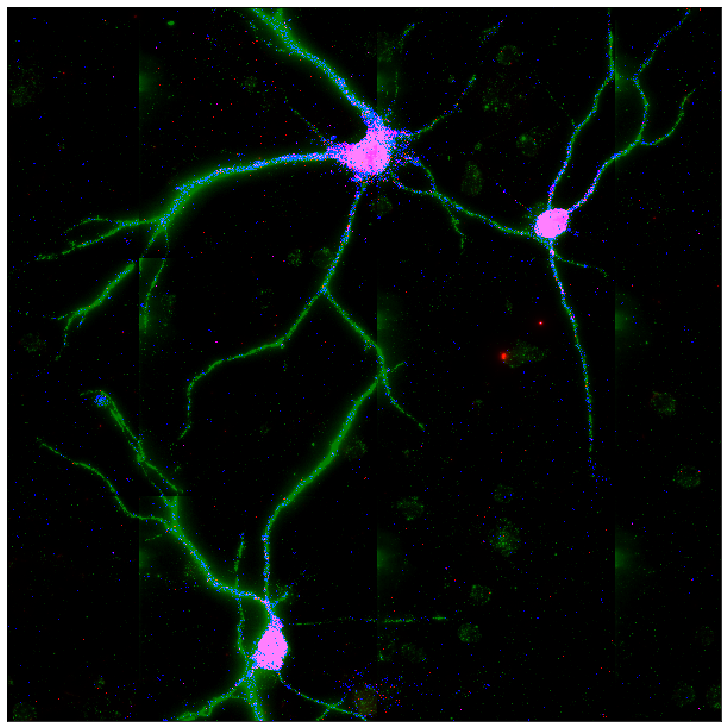

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [10]:
# plotting.implot(plotting.panel(preprocessed, bbox, 1), interpolation="None", name="preprocess")

## Thresholding Figure

In [11]:
from skimage.morphology import dilation, erosion, closing, opening, disk

imname = 'preprocessed_Probabilities.png'

datafile = datapath + imname
segProbIm = cv2.imread(datafile)

hi = 0.70
lo = 0.25
closerad = 8
dilrad = 5
lorad = 1
minsize = 250
holeMax = 2000
holeMin = 20

im = segProbIm[:,:,1]

# generate disk filters
closefilter = disk(closerad)
dilfilter = disk(dilrad)
lofilter = disk(lorad)

# threshold dendrites with high and low thresholds
hithresh,hiThresholdedDendrite=cv2.threshold(im,255*hi,255,cv2.THRESH_BINARY)
lothresh,loThresholdedDendrite=cv2.threshold(im,255*lo,255,cv2.THRESH_BINARY)

hibar = np.zeros(hiThresholdedDendrite.shape,dtype=np.int)
lobar = np.zeros(loThresholdedDendrite.shape,dtype=np.int)

hibar[hiThresholdedDendrite > 0] = 1
lobar[loThresholdedDendrite > 0] = 1

 # find large holes in high threshold to preserve true holes
holemask = morphology.remove_small_holes(hibar>0, holeMax) - hibar
holemask = morphology.remove_small_objects(holemask>0, holeMin)

# remove debris from low threshold
lobardil = morphology.remove_small_objects(lobar>0, min_size=minsize, connectivity=1)

# close hi threshold to bridge gaps
hibardil = closing(hibar, closefilter)

# smaller dilation to high threshold
hibardil = dilation(hibardil, dilfilter)

g = np.bitwise_and(hibardil>0,lobardil>0)
g[holemask > 0] = 0

C:\Users\Harrison\AppData\Local\Temp/ipykernel_17416/1785419226.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hibar = np.zeros(hiThresholdedDendrite.shape,dtype=np.int)
C:\Users\Harrison\AppData\Local\Temp/ipykernel_17416/1785419226.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

In [12]:
im = segProbIm[:,:,2]

hi = 0.9
lo = 0.1
dilrad = 8
holemin = 50

dilfilter = disk(dilrad)

# find high threshold and low threshold
somathresh, hiThresholdedSoma=cv2.threshold(im,255*hi,255,cv2.THRESH_BINARY)
somathresh, loThresholdedSoma=cv2.threshold(im,255*lo,255,cv2.THRESH_BINARY)

hiso = np.zeros(im.shape)
loso = np.zeros(im.shape)

hiso[hiThresholdedSoma > 0] = 1
loso[loThresholdedSoma > 0] = 1

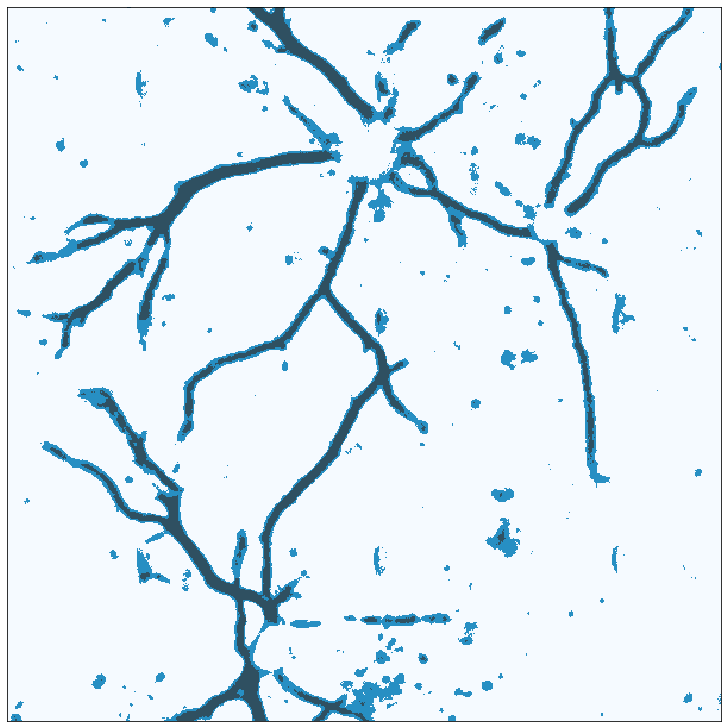

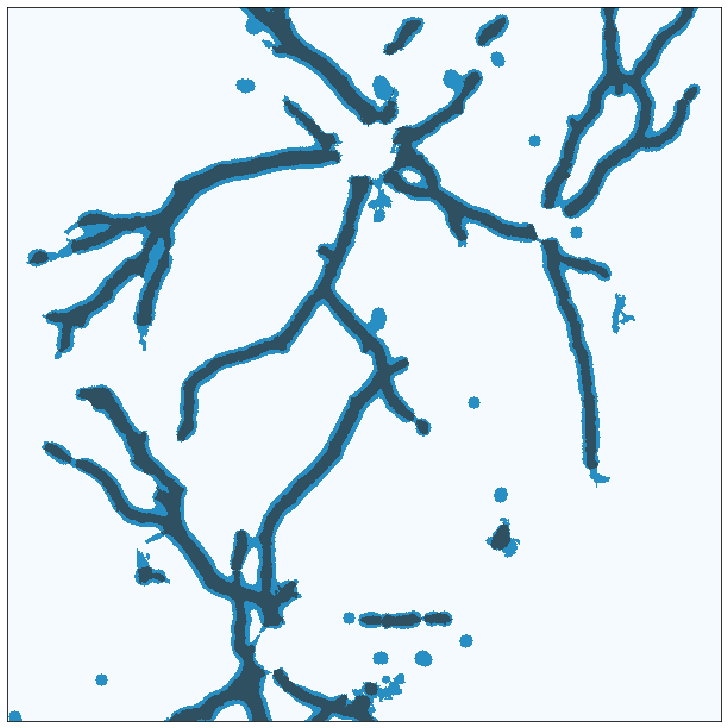

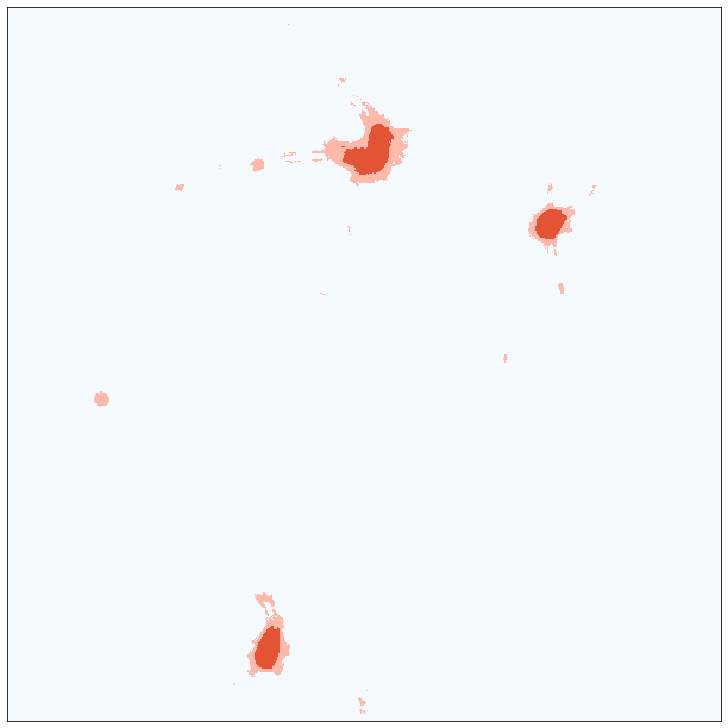

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [13]:
plotting.colorplot(plotting.panel(lobar+hibar, bbox, 1), two_blue, interpolation="None", name="hiandlothresholds")
plotting.colorplot(plotting.panel(lobardil+hibardil, bbox, 1), two_blue, interpolation="None", name="hiandlothresholdsdilated")
plotting.colorplot(plotting.panel(loso+hiso, bbox, 1), two_orange, interpolation="None", name="soma")

## Segmentation Figure

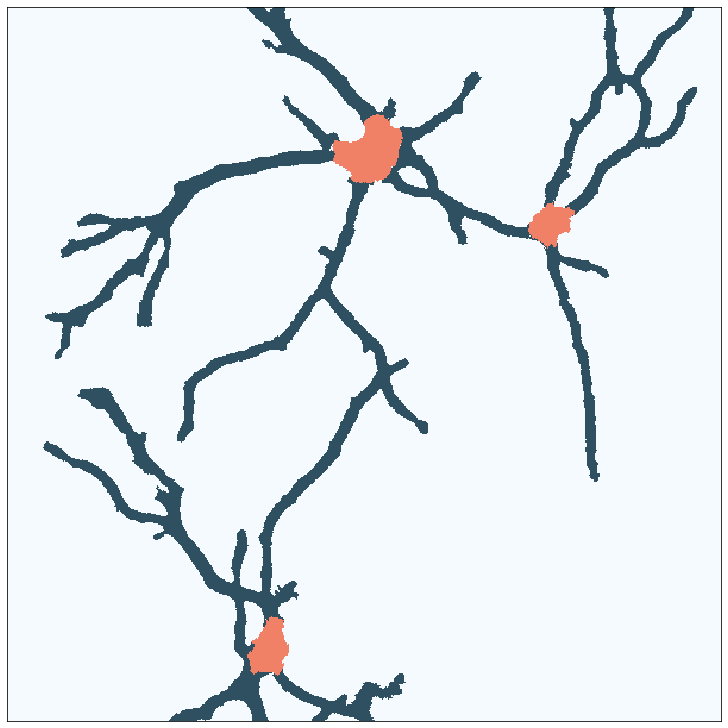

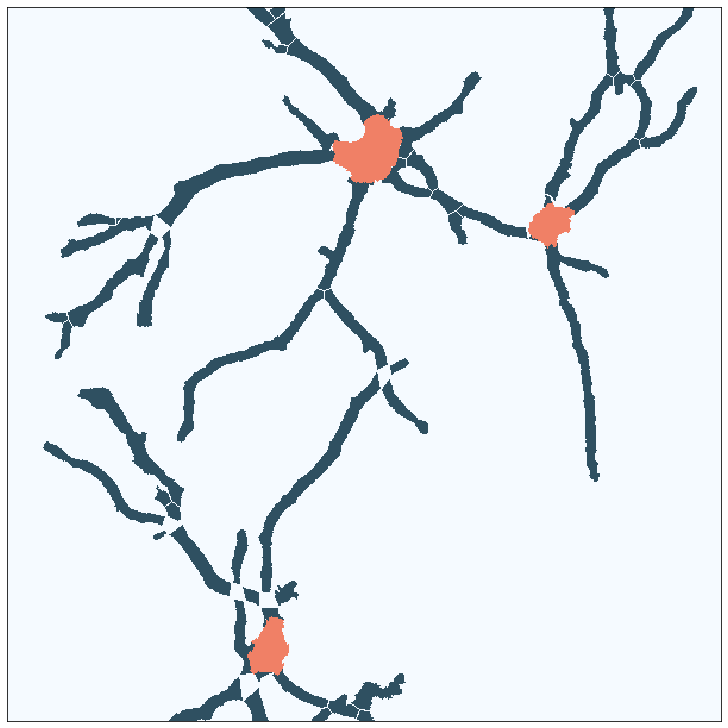

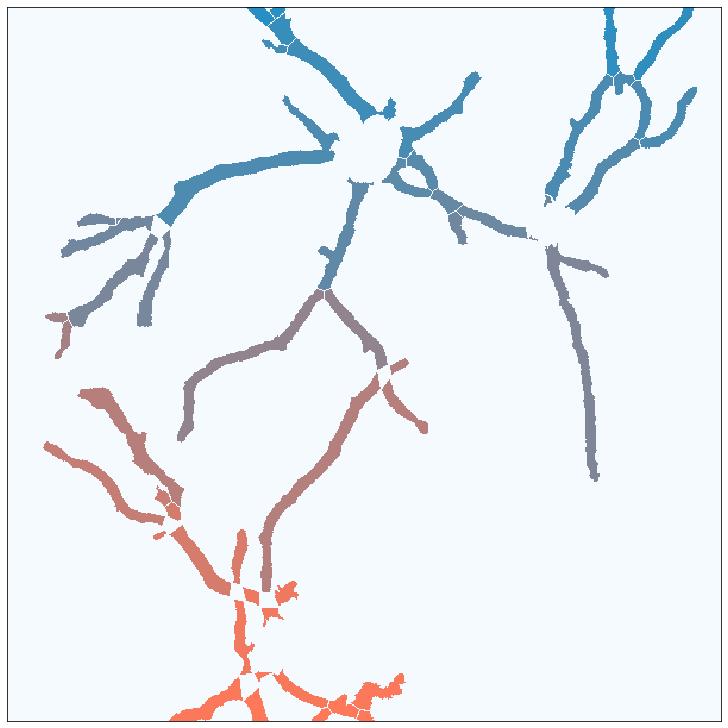

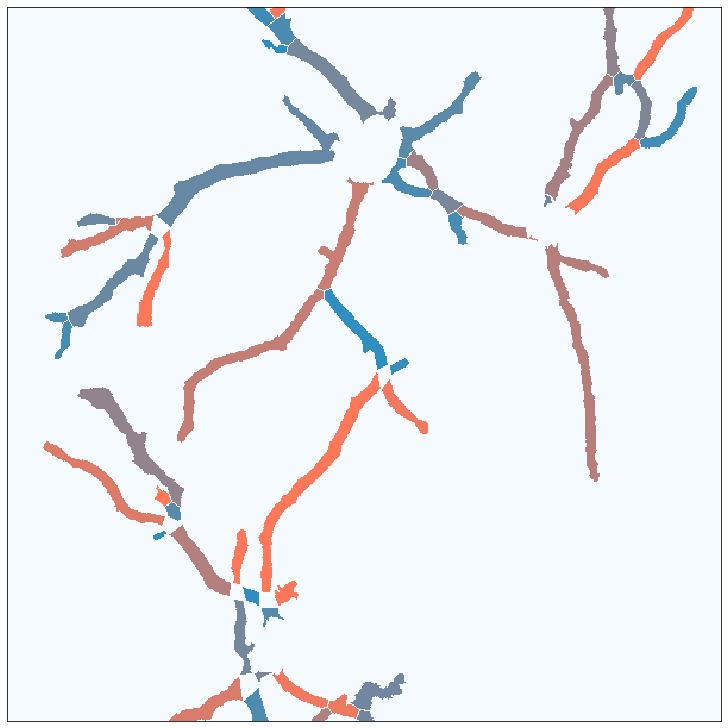

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [14]:
pre_segmentation_image = np.array((thresholdedProcessImage > 0) + 2*(somaImage > 0), dtype=float)
post_segmentation_image = np.array((processImage > 0) + 2*(somaImage > 0), dtype=float)
# total_image = np.array((humanProcessImage > 0) + 2*(humanBodyImage > 0), dtype=float)
# total_image = np.array((humanProcessImage > 0) + 2*(humanBodyImage > 0) - 1*((humanBodyImage > 0) * (humanProcessImage > 0)), dtype=float)

plotting.colorplot(plotting.panel(pre_segmentation_image, bbox, 1), two_map, interpolation="None", name="presegmentationimage")
plotting.colorplot(plotting.panel(post_segmentation_image, bbox, 1), two_map, interpolation="None", name="postsegmentationimage")
plotting.implot(plotting.panel(processImage, bbox, 1), name="processImage", cmap=two_map_mapped, interpolation="None")
plotting.implot(plotting.permute_image(plotting.panel(processImage, bbox, 1)), name="permuteProcessImage", cmap=two_map_mapped, interpolation="None")

In [15]:
from segmentation import *
"""
break an image down into segments, applying crossing and branch masks
"""
sampleskel = skeletonize(thresholdedProcessImage,method="lee")
sampleskel = morphology.remove_small_objects(sampleskel>0, min_size=15, connectivity=2)
shorts = rm_nubs(sampleskel,10)

for short in shorts:
    for y, x in short:
        sampleskel[y,x] = 0

sep, sbp, scp = find_endpts(sampleskel)


a,b = cross_close_branches(sbp, scp, 10)


samplemask = get_crossing_mask(thresholdedProcessImage, nby2_convert(b))
samplemask += get_branch_mask(thresholdedProcessImage, nby2_convert(a))
samplemask[samplemask > 0] = 1

segmentedsampleimage = thresholdedProcessImage - samplemask
segmentedsampleimage[segmentedsampleimage<1] = 0
segmentedsampleimage[segmentedsampleimage>=1] = 1



[  11   11   11 ... 4209 4209 4213]
[1423 1444 1707 ... 3096 3328 1771]
859 short branches found


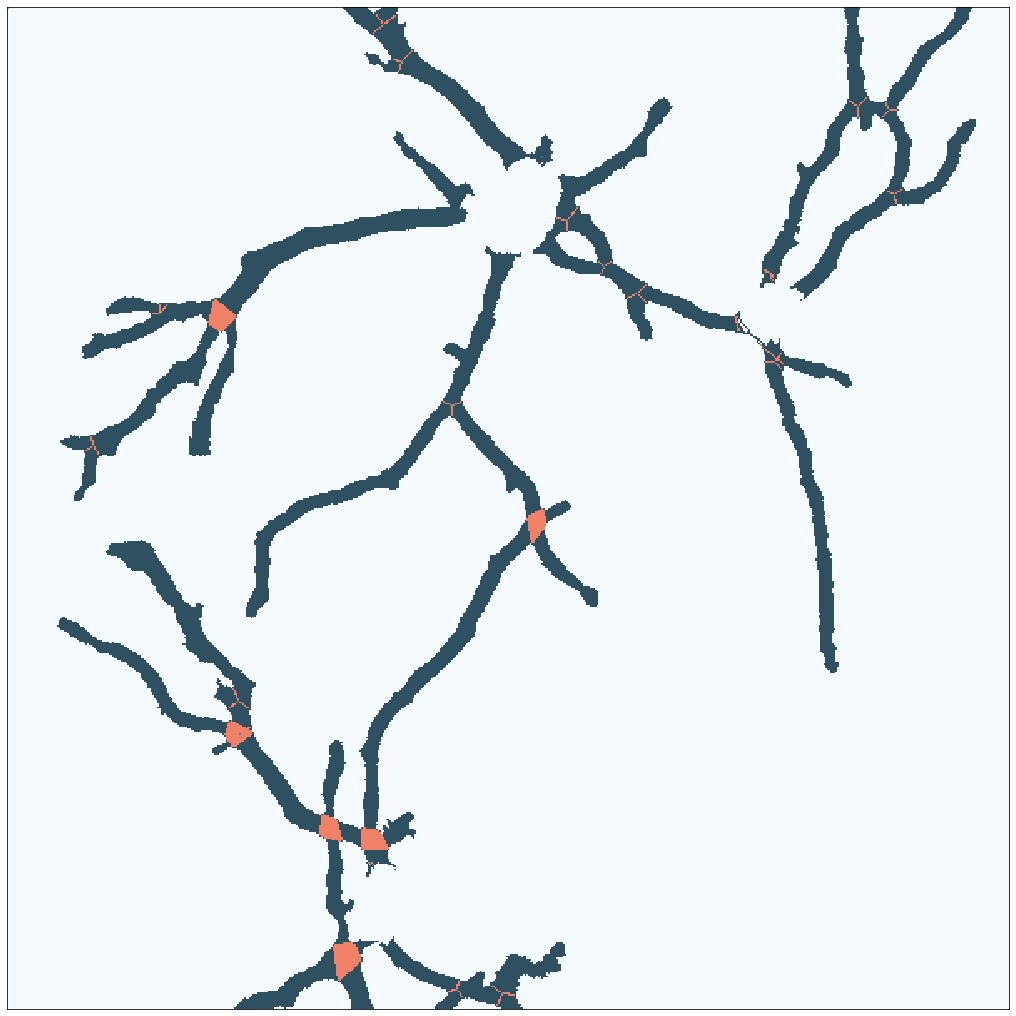

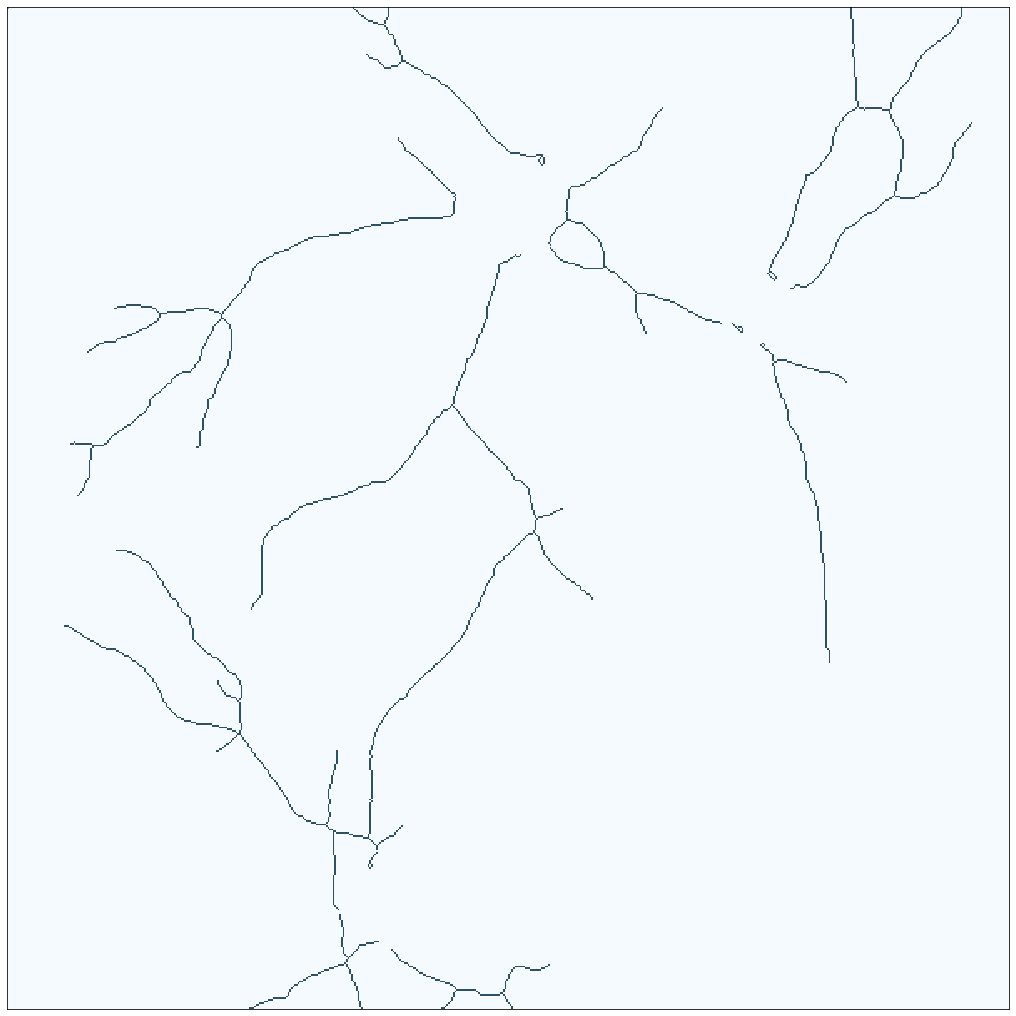

(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

In [16]:
plotting.colorplot(plotting.panel(thresholdedProcessImage + samplemask + a + 2*b, bbox, 1), two_map, interpolation="None", name="maskedProcessImage", figsize=(14,14))
plotting.colorplot(plotting.panel(1*(sampleskel>0), bbox, 1), two_map, interpolation="None", name="skeleton", figsize=(14,14))

## Test NMF Grouping

In [190]:
barcode_composition = transcriptomics.get_transcriptomes(RNA)
nmf = transcriptomics.apply_nmf(barcode_composition, 9)

C:\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


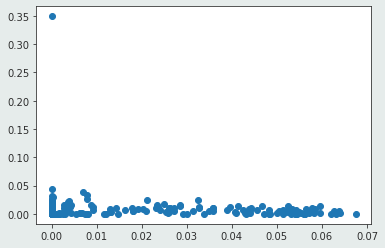

In [186]:
X = [item[1] for item in barcode_composition.items()]
X = np.vstack(X)
X_prime = nmf.transform(X)
plt.scatter(X_prime[:, 0], X_prime[:, 6])

In [176]:
class ColorByLatentEmbedding(basicrna.Colorizer):
    def __init__(self, components, k):
        self.components = components
        self.k = k

    def set_component(self, k):
        self.k = k

    def get_color(self, point):
        return self.components[self.k, point.barcode]

In [197]:
class ColorByHighest(basicrna.Colorizer):
    def __init__(self, highest_list, k):
        self.k = k
        self.highest_list = highest_list

    def get_color(self, pt):
        if self.k == 0:
            return 1
        return 1 if self.highest_list[pt.barcode] == self.k else 0

In [200]:
highest = np.argmax(nmf.components_[1:, :], axis=0) + 1
highest

array([5, 5, 7, ..., 3, 8, 3], dtype=int64)

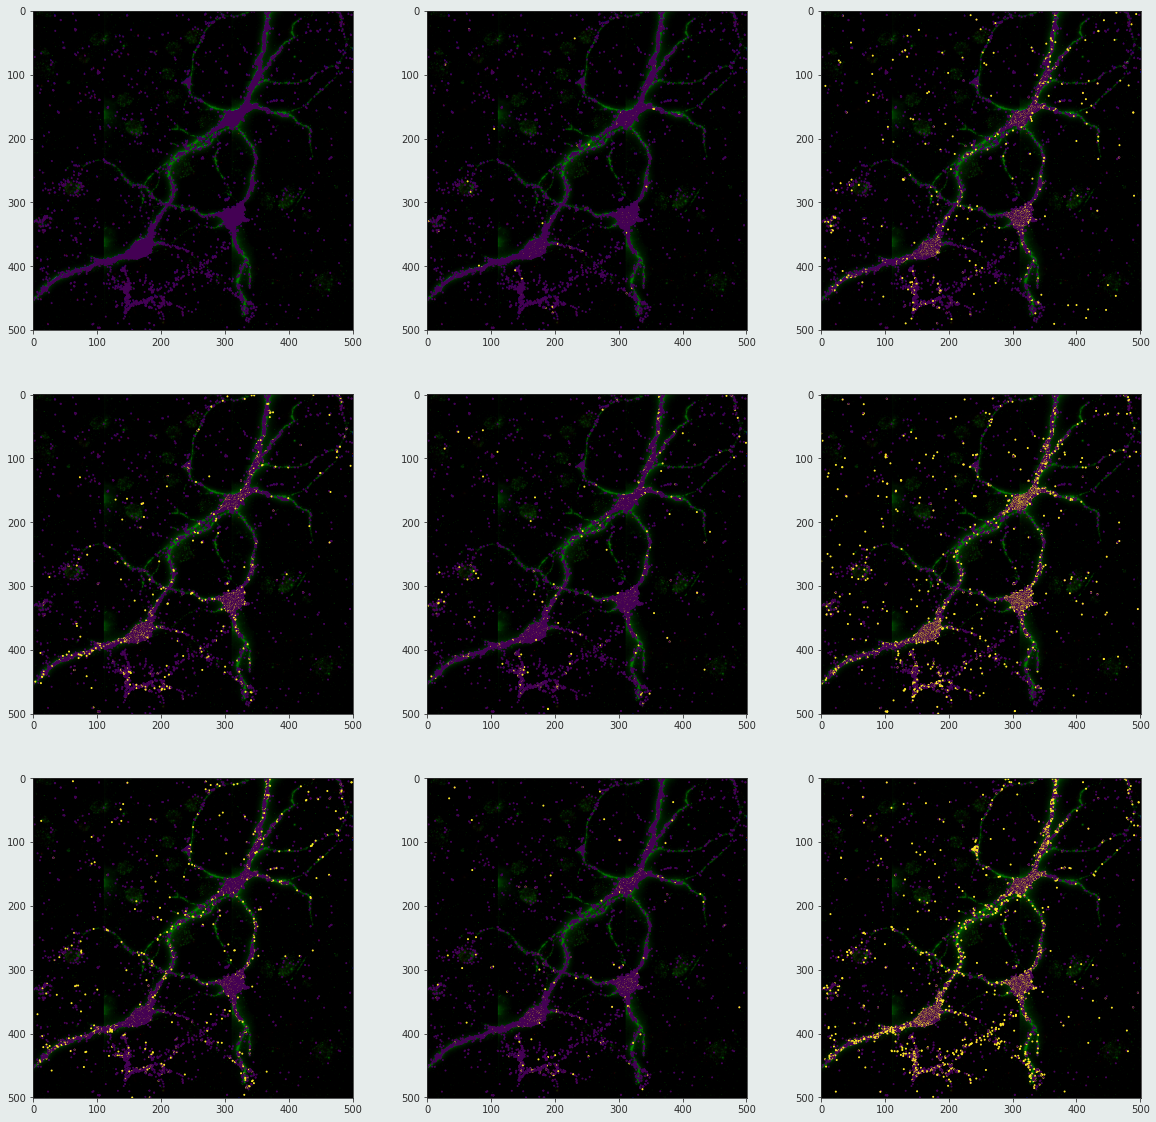

In [201]:
panel=0
rec = trees.Rect([bbox[panel][0], bbox[panel][1], 500, 500])
rec_rna = qtree.query(bbox=rec)

# fig = plt.figure(figsize=(10,10))
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(20,20))
for i in range(9):
    ax = axes[i // 3, i % 3]
    basicrna.plot_points(ax, rec_rna, image=preprocessed[rec.y:rec.ymax+1, rec.x:rec.xmax+1], offset=(rec.y, rec.x), colorizer=ColorByHighest(highest, i))
plt.show()

## Test Search Method

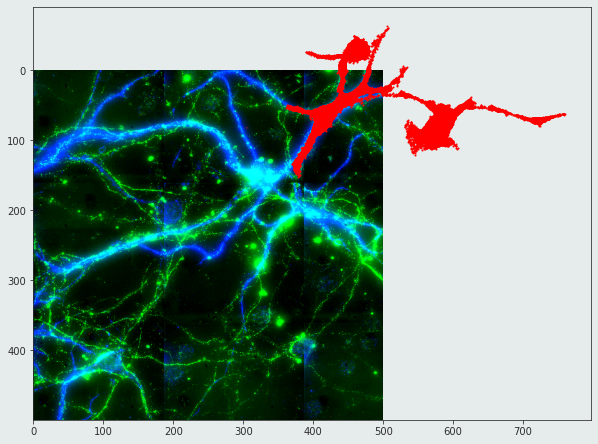

In [232]:
rec = trees.Rect([250, 1024, 500, 500])
rec_rna = qtree.query(bbox=rec)
start_point = np.random.choice(rec_rna)
searcher = search.PointExplorer(mini_qtree)
search_method = search.RadiusSearch(qtree, 3)
add_method = search.AddMethod()
searcher.start_point(start_point)
searcher.expand(search_method, add_method)

bgimage = np.array(cv2.imread(datapath+"Map2TauImage.png")[rec.y:rec.y+rec.h, rec.x:rec.x+rec.w])
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_facecolor('#e6eceb')
basicrna.plot_points(ax, searcher.accepted, image=bgimage, offset=(rec.y, rec.x))
plt.show()

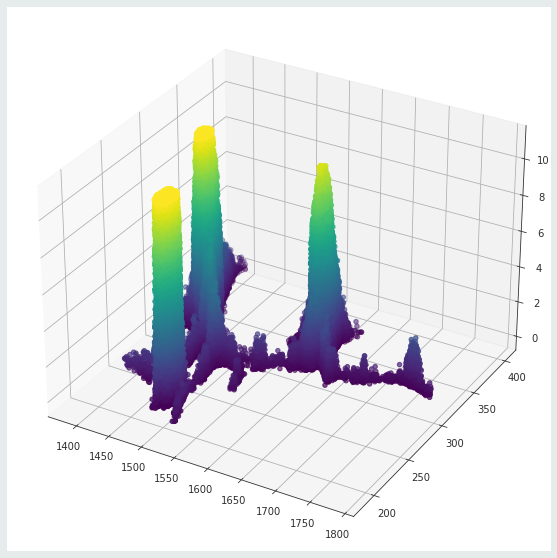

In [236]:
from mpl_toolkits import mplot3d

rna_list = searcher.accepted
ys = [pt.y for pt in rna_list]
xs = [pt.x for pt in rna_list]
zs = [pt.z for pt in rna_list]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(xs, ys, zs, c=zs)

plt.show()

## Find High Variance Barcodes

In [207]:
barcodes = Counter(RNA['barcode_id'])
soma_cells = Counter(RNA[RNA['process_index'] == 0]['cell_index'])
process_cells = Counter(RNA[RNA['process_index'] > 0]['cell_index'])

soma_counts = np.zeros(np.max(list(soma_cells.keys())) + 1)
process_counts = np.zeros(np.max(list(soma_cells.keys())) + 1)
barcodes_counts = np.zeros(1240)
for key in barcodes:
    barcodes_counts[key] = barcodes[key]

for key in soma_cells:
    soma_counts[key] = soma_cells[key]

for key in soma_cells:
    process_counts[key] = process_cells[key]

max_soma_cells = np.argsort(soma_counts)[::-1]
max_process_cells = np.argsort(process_counts)[::-1]
max_codes = np.argsort(barcodes_counts)[::-1]
max_codes

array([569, 505, 781, ..., 107, 171, 113], dtype=int64)

## Barcode Qtrees

In [9]:
barcode_qtrees, barcode_rna_lists = trees.generate_barcode_qtrees(rna_list, image_rect)
# fig, ax = plt.subplots()
# barcode_qtrees[540].plot_points(ax)
# plt.show()

656132it [00:06, 105974.66it/s]


## Density Measurements

In [10]:
n = 40000
rna_subset = np.random.choice(rna_list, n, False)

n_neighbors = np.zeros(n)
all_neighbors = [None for _ in range(n)]
type_list = ["unlabeled" for _ in range(n)]
for i, pt in tqdm(enumerate(rna_subset)):
    neighbors = qtree.radius_query((pt.y, pt.x), 5, getter=trees.Getter())
    n_neighbors[i] = len(neighbors)
    all_neighbors[i] = neighbors

    if pt.cell > 0:
        if pt.processIndex > 0:
            type_list[i] = "process"
        else:
            type_list[i] = "soma"

density = n_neighbors/(np.pi * 25)
rna_subset_table = pd.DataFrame({"density" : density,
                                 "type" : type_list,
                                 "barcode" : [point.barcode for point in rna_subset],
                                "cell": [point.cell for point in rna_subset]})

40000it [00:55, 721.19it/s]


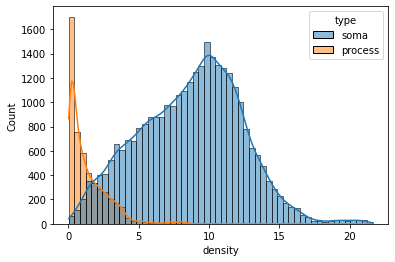

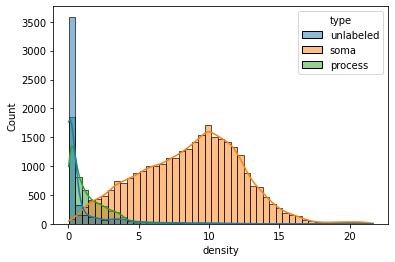

In [11]:
plt.figure()
sns.histplot(rna_subset_table[rna_subset_table["type"] != "unlabeled"], x="density", hue="type", kde=True)
plt.show()
plt.figure()
sns.histplot(rna_subset_table, x="density", hue="type", kde=True)
plt.show()

## Density Change as Distance from Cell

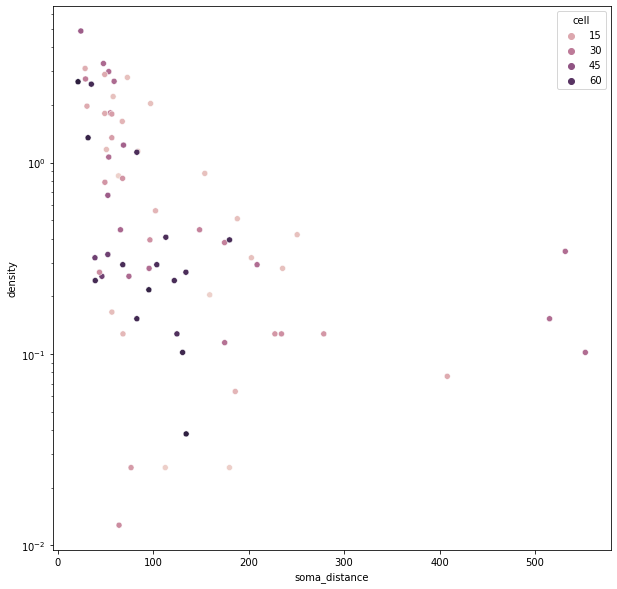

In [12]:
soma_distance = [point.somaDistance for point in rna_subset]
rna_subset_table['soma_distance'] = soma_distance

process_subset = rna_subset_table[rna_subset_table['type']=='process']

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=process_subset[process_subset['barcode'] == 520], y='density', hue='cell', x='soma_distance', ax=ax)
ax.set_yscale('log')
plt.show()

## Gradient Calculations

In [13]:
average_loc = np.zeros((n, 2))
average_delta = np.zeros((n, 2))

for i, pt in tqdm(enumerate(rna_subset)):
    neighbors = all_neighbors[i]
    average_x = np.average([neighbor.x for neighbor in neighbors])
    average_y = np.average([neighbor.y for neighbor in neighbors])
    average_loc[i, :] = [average_y, average_x]
    average_delta[i, :] = [average_y - pt.y, average_x - pt.x]

rna_subset_table["local_delta_x"] = average_delta[:,1]
rna_subset_table["local_delta_y"] = average_delta[:,0]

40000it [00:12, 3271.24it/s]


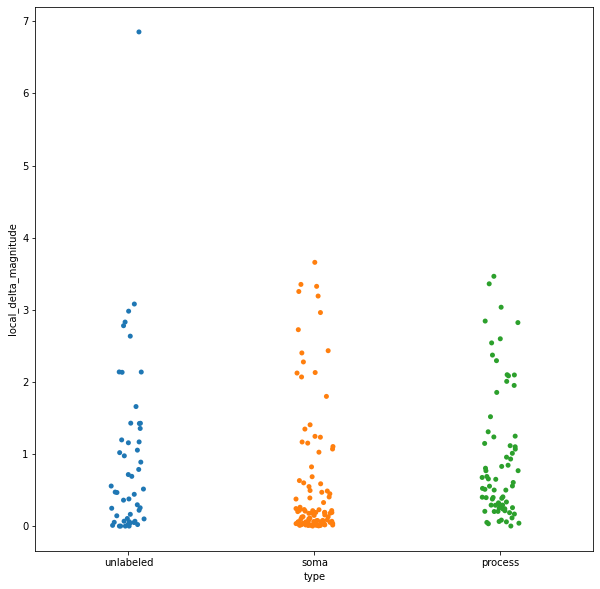

In [14]:
rna_subset_table["local_delta_magnitude"] = (rna_subset_table["local_delta_x"]**2 + rna_subset_table["local_delta_y"]**2)**1/2
fig, ax = plt.subplots(figsize=(10,10))
sns.stripplot(data=rna_subset_table[rna_subset_table["barcode"]==1170], y="local_delta_magnitude", x="type", ax=ax)
# sns.kdeplot(data=rna_subset_table, x="local_delta_magnitude", hue="type", ax=ax)
plt.show()

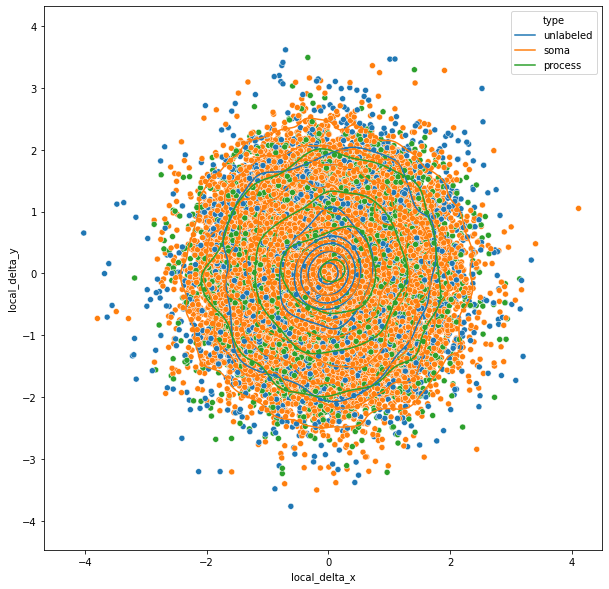

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=rna_subset_table, hue="type", x="local_delta_x", y="local_delta_y", ax=ax)
sns.kdeplot(data=rna_subset_table, hue="type", x="local_delta_x", y="local_delta_y", ax=ax)
plt.show()

## Barcode Density Measurements

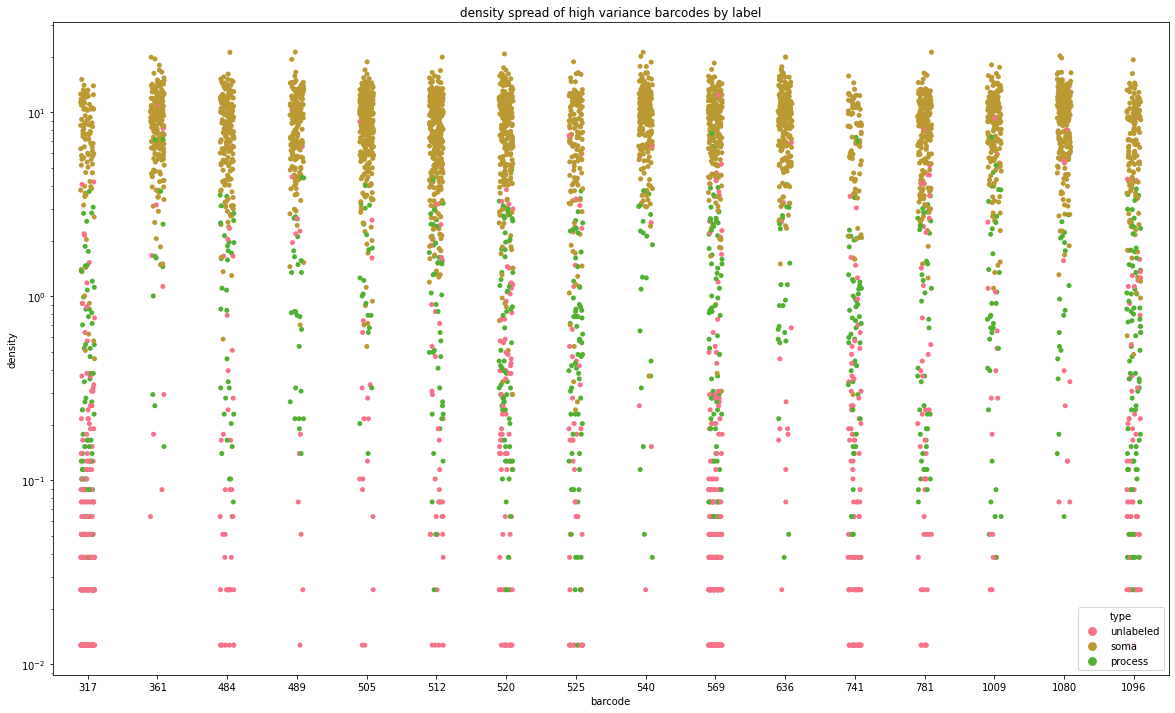

In [16]:
n = 16
high_var_codes = max_codes[:n]
high_var_samples = rna_subset_table[np.isin(rna_subset_table["barcode"], high_var_codes)]
fig, ax = plt.subplots(figsize = (20, 12))
sns.set_palette("husl")
ax.set_facecolor((0,0,0,0))
sns.stripplot(data=high_var_samples, y="density", x="barcode", hue="type", ax = ax)
ax.set_yscale('log')
ax.set_title("density spread of high variance barcodes by label")
plt.show()

# nrows = 4
# ncols = 4
# fig, axes = plt.subplots(nrows,ncols,figsize=(20,20))
# print(axes.shape)
# for i in range(nrows*ncols):
#     code = max_codes[i]
#     ax = axes[i // ncols, i % ncols]
#     sns.histplot(data=rna_subset_table[rna_subset_table["barcode"] == code], x="density", hue="type", kde=True, ax=ax)
#     ax.set_xlabel(f'{max_codes[i]}')
#
# plt.show()

## RCV Embedding

In [17]:
# n_genes = 1240
#
# # def get_rcv(point, k, tree: Qtree):
# #     vec = np.zeros(n_genes)
# #     neighbors = tree.get_nn(point, k, 40)
# #     ids = [int(neighbor.barcode) for neighbor in neighbors]
# #     for id in ids:
# #         vec[id] += 1
# #     return vec
#
# def get_rcvs(rna_vec, k, tree:Qtree):
#     rcvs = np.zeros((len(rna_vec), n_genes))
#     for i, pt in tqdm(enumerate(rna_vec)):
#         tree.get_nn(pt, k, 40, rcv=rcvs, id=i)
#
#     return rcvs
#
# n = 10000
#
# basis = np.random.choice(np.arange(len(rna_list)), n)
# rna_vec = [rna_list[i] for i in basis]
# rcv_vec = get_rcvs(rna_vec, 500, qtree)

In [18]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
#
# pca = PCA()
# pca.fit(rcv_vec)
# var = pca.explained_variance_
# embedded = pca.transform(rcv_vec)
# reducer = TSNE(n_components=3, init='pca')
# embedding = reducer.fit_transform(embedded[:,:15])
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(embedding[:,0], embedding[:,1], embedding[:,2])
# plt.show()

In [19]:
# def embed_rcv(rcv, pca:PCA, tsne:TSNE, tsne_fitted):
#     pca_reduced = pca.transform(rcv)
#     tsne_mapped = tsne.fit_transform(pca_reduced)
#     medians = np.median(np.abs(tsne_mapped), axis=0)
#     normed = np.clip(tsne_mapped/(2*medians), -1, 1)
#     return normed

## Generate Cell Species Image

In [224]:
class ColorByZ(basicrna.Colorizer):
    def get_color(self, pt):
        return pt.z

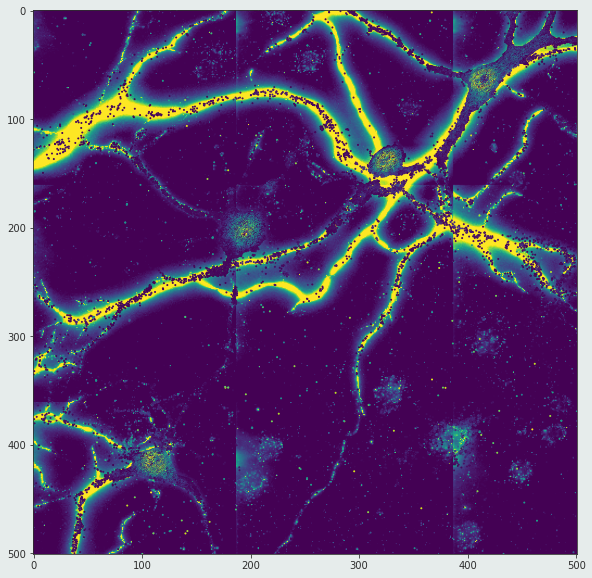

In [226]:
# rec = trees.Rect([250, 1024, 500, 500])
bgimage = np.array(cv2.imread(datapath+"Map2TauImage.png")[rec.y:rec.y+rec.h+1, rec.x:rec.x+rec.w+1])

fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.set_facecolor('#e6eceb')
points = qtree.query(rec)
basicrna.plot_points(ax, points, colorizer=ColorByZ(), image=bgimage[:,:,2]/2, offset=(rec.y, rec.x))

plt.show()

## High Variance Barcodes Image

(4, 4)


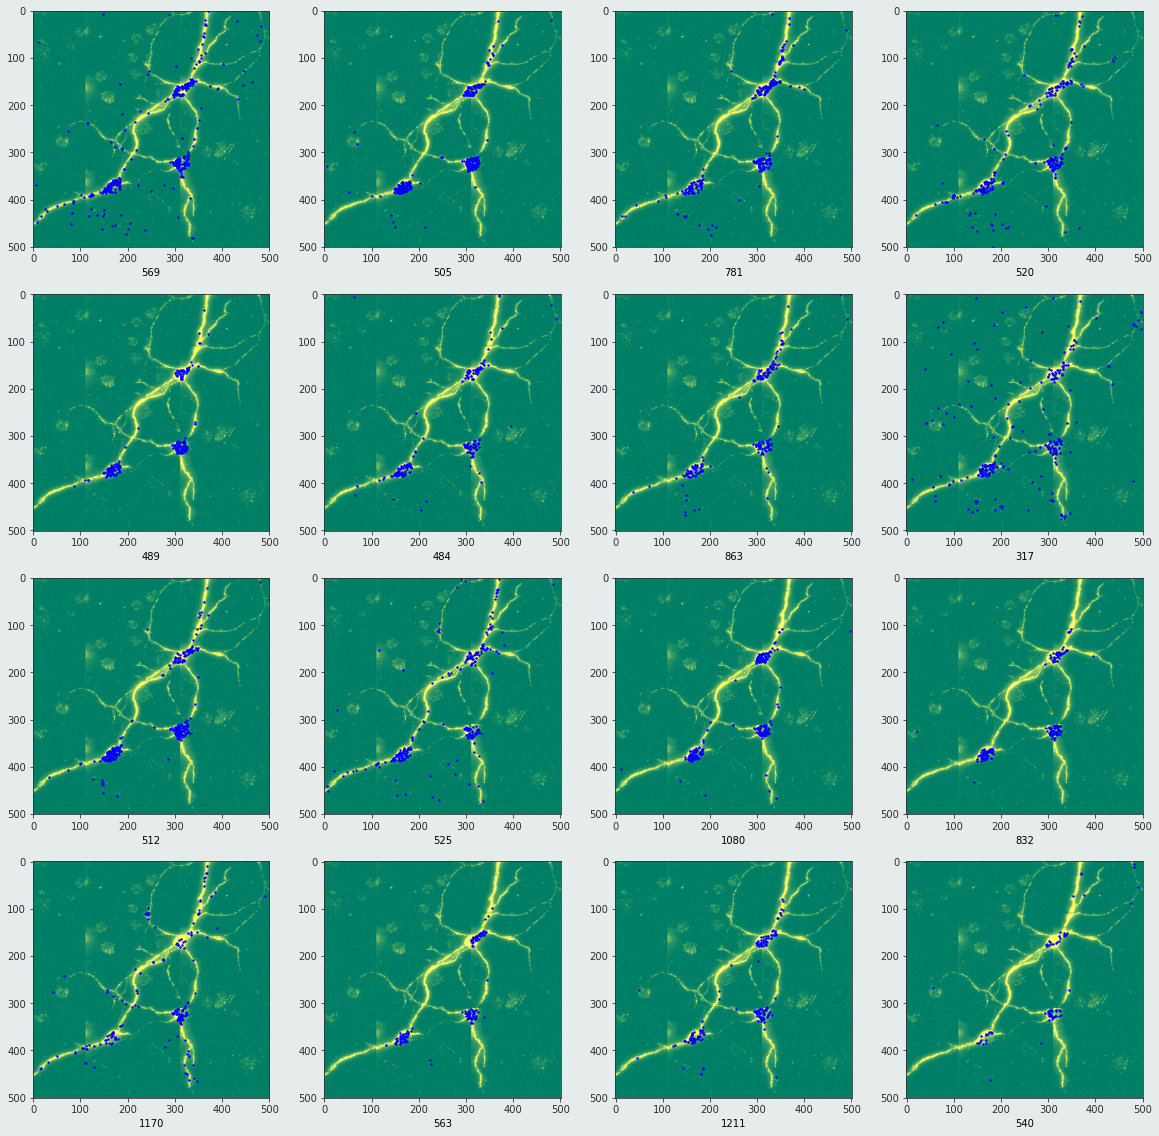

In [217]:
rec = trees.Rect([700, 700, 500, 500])
# bgimage = np.array(cv2.imread(datapath+"Map2TauImage.png")[rec.y:rec.y+rec.h, rec.x:rec.x+rec.w])

nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows,ncols,figsize=(20,20))
print(axes.shape)
for i in range(nrows*ncols):
    tester = trees.BarcodeTester(max_codes[i])
    ax = axes[i//ncols][i%ncols]
    points = qtree.query(rec, tester=tester)
    basicrna.plot_points(ax, points, c='blue', s=2, image=bgimage[:,:,2], offset=(rec.y, rec.x), cmap="summer")
    ax.set_xlabel(f'{max_codes[i]}')

plt.show()

In [16]:
import importlib
importlib.reload(search)

<module 'search' from 'C:\\Lab Work\\segmentation\\Segmentation\\search.py'>

## Diffusion Experiment

### Build process and soma objects

In [23]:
# processes = branches.buildProcesses(processImage, RNA)
# somas = branches.buildSomas(somaImage, RNA)

In [24]:
# bbs = [[300,1000,500,500],[2500,2700,500,500]]
#
# baseimgfile = datapath+"preprocessed.png"
# baseimg = cv2.imread(baseimgfile)
#
# probimname = 'preprocessed_Probabilities.png'
# datafile = datapath + probimname
# segProbIm = cv2.imread(datafile)
#
# # plotting.embedimg(baseimg, bbs, plotpath)
# # plotting.embedimg(segProbIm, bbs, datapath, name="probabilities")
# # plotting.embedimg(processImage, bbs, datapath, name="processImg")

In [25]:
# for process in list(processes.values())[:20]:
#     neighbors = process.getNeighbors(somaImage, 'soma', 10)

In [26]:
# branch_list = []
# for process in list(processes.values())[:20]:
#     for soma in process.neighbors['soma']:
#         root = branches.Root(somas[soma])
#         branch_list.append(branches.Branch(root, process))
# branch_list[4].plot()

In [27]:
# plotting.implot(branch_list[4].disIm)

In [28]:
# for i, branch in enumerate(branch_list[:5]):
#     rnaids, rnadists = branch.get_rnadistances(True)
    # plotting.plotKDE(rnadists, "RNA distribution along candidate branch", savefile=datapath+f'rnabranch{i}.png')

In [29]:
# for branch in branch_list[:5]:
#     process = branch.end
#     soma = branch.source.end
    # print(process.ymin, process.xmin, process.label, process.neighbors)
    # print(soma.ymin, soma.xmin, soma.label)
    # plotting.implot(1*(processImage[branch.ymin:branch.ymax,branch.xmin:branch.xmax]==process.label) + (somaImage[branch.ymin:branch.ymax,branch.xmin:branch.xmax]==soma.label)*2, datapath, show=False)
    # plotting.implot((somaImage[branch.ymin:branch.ymax,branch.xmin:branch.xmax]==soma.label)*2, datapath, show=False)
    # plt.show()

In [ ]:
# import pyro
# import pyro.distributions as dist
# import torch.distributions.constraints as constraints
# import torch
# from pyro.optim import Adam
# from pyro.infer import SVI, Trace_ELBO
#
# branch = branch_list[4]
#
# # clear the param store in case we're in a REPL
# pyro.clear_param_store()
#
# def model(data):
#     # beta = dist.Uniform('beta',low=torch.tensor(0.0), high=torch.tensor(1.0))
#     # sigma = dist.Bernoulli('sigma',p=beta)
#     lam_0 = pyro.sample('latent_rate', dist.Beta(torch.tensor([1.0]),torch.tensor([1.0])))
#     # x = dist.Uniform('x',np.min(branch.rnadists),np.max(branch.rnadists))
#     for i in range(len(data)):
#         x = pyro.sample(f'distance_{i}', dist.Exponential(lam_0), obs=data[i])
#
# def guide(data):
#     alpha_q = pyro.param("alpha_q", torch.tensor([1.0]), constraint=constraints.positive)
#     beta_q = pyro.param("beta_q", torch.tensor([1.0]), constraint=constraints.positive)
#     pyro.sample("latent_rate", dist.Beta(alpha_q,beta_q))
#
# # setup the optimizer
# adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
# optimizer = Adam(adam_params)
#
# # setup the inference algorithm
# svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
#
# data = torch.from_numpy(branch.rnadists)
# n_steps = 200
#
# # do gradient steps
# for step in range(n_steps):
#     svi.step(data)
#     if step % 20 == 0:
#         alpha = pyro.param("alpha_q").item()
#         beta = pyro.param("beta_q").item()
#         inferred_mean = alpha / (alpha + beta)
#         print(step, inferred_mean)

In [ ]:
# alpha = pyro.param("alpha_q").item()
# beta = pyro.param("beta_q").item()
# inferred_mean = alpha / (alpha + beta)
# print(1/inferred_mean)

In [ ]:
# print(alpha,beta)

In [ ]:
# import seaborn as sns

In [ ]:
# rate_dist = dist.Beta(alpha,beta)
# x = torch.tensor(np.arange(0.01,0.1,0.001))
# plt.plot(x,np.exp(rate_dist.log_prob(x)))
# plt.ylabel("P(lam|data)")
# plt.xlabel("lam")
# plt.title("Posterior Distribution of Rate Parameter")
# plt.show()
# x = torch.tensor(np.arange(1,220,1))
# plt.plot(x,np.exp(dist.Exponential(inferred_mean).log_prob(x)),label="P(x|lamda)")
# plt.plot(x,np.exp(dist.Exponential(1/np.mean(branch.rnadists)).log_prob(x)),label="MLE P(x|lamda)")
# sns.kdeplot(branch.rnadists, label="True distribution",bw_method=0.02)
# plt.xlabel("distance from soma (px)")
# plt.title("Exponential Fit to Data")
# plt.legend()
# plt.xlim(xmin=0)
# plt.show()

In [ ]:
# import pyro
# import pyro.distributions as dist
# import pyro.poutine as poutine
# from pyro.infer import MCMC, NUTS
#
# # pyro.set_rng_seed(0)
# pyro.clear_param_store()
#
# def model(data):
#     beta = pyro.param('prob_above',torch.tensor([0.5]),constraint=constraints.interval(0,1))
#     sigma = pyro.sample('bool_above', dist.Bernoulli(beta))
#
#     lam = pyro.param('latent_rate',torch.tensor([0.5]),constraint=constraints.positive)
#     delta = pyro.param('delta', dist.Exponential(lam))
#     x = pyro.sample("source", dist.Uniform(torch.tensor(data.min()),torch.tensor(data.max())))
#
#     position = (2*sigma - 1)*delta + x
#
#     i = np.random.randint(len(data))
#     pyro.sample('obs', dist.Normal(position, 0.05), obs=data[i])
#
# # def conditioned_model(model, sigma, y):
# #     return poutine.condition(model, data={"obs": y})(sigma)
#
# nuts_kernel = NUTS(model)
# mcmc = MCMC(
#     nuts_kernel,
#     num_samples=1000,
#     num_chains=1,
# )
#
# data = torch.from_numpy(branch.rnadists)
#
# mcmc.run(data)
# mcmc.summary(prob=0.5)